In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

import scipy.io

from sklearn.decomposition import PCA

C:\Users\vladka\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# original dataset pixels have values in [-1, 1]
# so we need to scale it to use sigmoid in our NN
def normalize(batch):
    batch = batch - np.mean(batch)
    
    pstd = 3*batch.std()
    
    batch[batch >= pstd] = pstd
    batch[batch <= -pstd] = -pstd;
    
    batch /= pstd
    
    batch = (batch+1)*0.4 + 0.1
    
    return batch

def get_random_patch(data, patch_size=8):
    im_num = np.random.randint(0, len(data))
        
    r, c = np.random.randint(0, data[im_num].shape[0] - patch_size), np.random.randint(0, data[im_num].shape[1] - patch_size)
    
    return data[im_num][r:r+patch_size, c:c+patch_size]

# given data this function returns batch with given size
# patch size defines one dimension of patches that will be selected randomly
# if patch size = 8 , total size of patch would be 8x8 = 64
def get_batch(data, batch_size, patch_size):
    batch = np.zeros((batch_size, patch_size*patch_size), dtype=float)
    
    for i in range(batch_size):
        batch[i] = get_random_patch(data, patch_size).flatten()
        
    return batch

In [3]:
# fully connected layer
# tensor - previous tensor
# w_size - size of the weight matrix, smth like (input size, output size)
# b_size - size of the bias vector, smth like (output_size,)
# name - name of the layer
# activation - activation function, smth like tf.nn.sigmoid
#              for this project we will use sigmoid functions because we want to use KL loss for sparsity 

def create_fc_layer(tensor, w_size, b_size, name, activation):
    r = np.sqrt(6) / np.sqrt(w_size[0] + w_size[1] + 1)

    W = tf.Variable(tf.random_uniform(w_size, minval=-r, maxval=r, dtype=tf.float32), name=name + '.w')
    b = tf.Variable(tf.constant(0., shape=(b_size,), dtype=tf.float32), name=name + 'bias')

    return W, activation(tf.matmul(tensor, W) + b)

# class to represent sparse autoencoder. Trying to give it sklearn-like interface
# num_input - size of the input vector
# num_hidden - size of the hidden layer (only one at this moment)
# max_iters - number of iterations for cost function optimization (only for scipy interface)
# optimizer - optimizer class from tf.train (smth like tf.train.AdamOptimizer)
# lr - learning rate
# beta - coefficient for KL sparse loss
# prob - target probability for activation
# weight_lambda - coefficient for weight regularization
# optim_type = type of optimization, if equals to 'scipy' scipy interface called (for natural images better)
#              otherwise use 'gradient' with optimizer

class SparseAutoencoder(object):
    def __init__(self, num_input, num_hidden, max_iters=500, optimizer=tf.train.AdamOptimizer, lr=0.01,
                 beta=3., prob=0.01, weight_lambda=0.0001, act_lambda = 0.001, optim_type='gradient'):
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.beta = beta
        self.weight_lambda = weight_lambda
        self.max_iters = max_iters
        self.optim_type = optim_type
        self.act_lambda = act_lambda

        self.sparsity_level = prob

        # model
        self.x = tf.placeholder(tf.float32, [None, self.num_input])
        [self.enc_weights, self.hidden_layer] = create_fc_layer(self.x, (self.num_input, self.num_hidden),
                                                                self.num_hidden,
                                                                name='encoder', activation=tf.nn.sigmoid)

        [self.dec_weights, self.reconstruction] = create_fc_layer(self.hidden_layer, (self.num_hidden, self.num_input),
                                                                  self.num_input, name='decoder',
                                                                  activation=tf.nn.sigmoid)

        self.cost = self.get_sparse_loss()
        
        # dirty! refactor it.
        if self.optim_type == 'scipy':
            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                self.cost,
                method='L-BFGS-B',
                options={'maxiter': max_iters})
        else:
            self.optimizer = optimizer(learning_rate=lr).minimize(self.cost)

        init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(init)

    def fit(self, X):
        # dirty! refactor it.
        if self.optim_type == 'scipy':
            pbar = tqdm.tqdm_notebook(total=self.max_iters)
            loss_history = list()
            def _update_pbar():
                pbar.update(1)

            self.optimizer.minimize(self.session, feed_dict={self.x: X}, loss_callback=_update_pbar)
        else:
            cost, opt = self.session.run((self.cost, self.optimizer), feed_dict = {self.x: X})
            return cost
    
    def get_sparse_loss(self):
        subj_mse = tf.reduce_sum(tf.pow(self.x - self.reconstruction, 2), axis=1)
        self.mse_loss = 0.5 * tf.reduce_mean(subj_mse)
        
        # sparsity for activation using KL divergence
        p_hat = tf.reduce_mean(self.hidden_layer, axis=0)
        left = self.sparsity_level * tf.log(self.sparsity_level / p_hat)
        right = (1 - self.sparsity_level) * tf.log((1 - self.sparsity_level) / (1 - p_hat))
        self.kl_loss = self.beta * tf.reduce_sum(left + right)
        
        # sparsity for activation using l1 loss
        self.sp_loss = self.weight_lambda * tf.reduce_sum(tf.abs(self.hidden_layer))
        
        # weight regularization. Helps to 'sharpen' features and gives more interpretation to them
        self.reg_loss = self.weight_lambda * (tf.nn.l2_loss(self.enc_weights) + tf.nn.l2_loss(self.dec_weights))
        
        return self.mse_loss + self.reg_loss + self.kl_loss + self.act_lambda*self.sp_loss

    def calculate_total_cost(self, X):
        return self.session.run(self.cost, feed_dict={self.x: X})

    def calc_mse_loss(self, X):
        return self.session.run(self.mse_loss, feed_dict={self.x: X})

    def calc_kl_loss(self, X):
        return self.session.run(self.kl_loss, feed_dict={self.x: X})
    
    def encode(self, X):
        return self.session.run(self.hidden_layer, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.session.run(self.reconstruction, feed_dict={self.x: X})

    def get_weights(self):
        return self.session.run(self.enc_weights)


In [104]:
images = sio.loadmat('data/IMAGES.mat')['IMAGES']
images = np.rollaxis(images, 2)

In [24]:
patch_size = 8
batch_size = 50000

num_iters = 500

hidden_size = 16

In [25]:
batch = get_batch(images, batch_size, patch_size)
batch = normalize(batch)

In [26]:
m = SparseAutoencoder(patch_size*patch_size, hidden_size, max_iters=num_iters, optim_type='scipy')
m.fit(batch)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.471437
  Number of iterations: 464
  Number of functions evaluations: 495


### Learn basic features from patches

Trying to reproduce results from Bruno A. Olshausen & David J. Field paper. https://www.nature.com/articles/381607a0

I expect to see straight lines with contrast edges.

And the results are similar with paper.

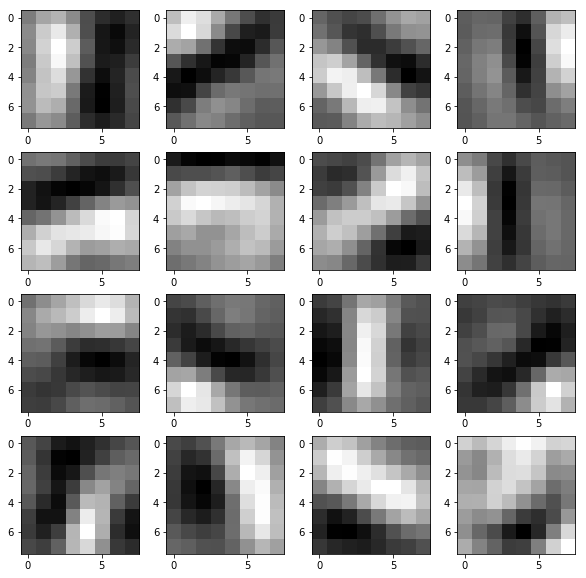

In [27]:
w = m.get_weights()

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for ax, img in zip(axes.flatten(), w.T):
    ax.imshow(img.reshape((8,8)), cmap='gray')

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [82]:
mnist_hidden = 36

In [83]:
m = SparseAutoencoder(28*28, mnist_hidden, prob=0.01, weight_lambda=0.00015, optimizer=tf.train.AdamOptimizer, lr=0.01)

In [84]:
for _ in tqdm.tnrange(5000):
    mnist_batch, _ = mnist.train.next_batch(256)
    mnist_batch = normalize(mnist_batch)
    m.fit(mnist_batch)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

### Learn from MNIST images

Trying to learn some digits features from MNIST dataset.

I expect to see more complex features than in previous network. Something like curve lines, digits edges etc.

Results are more interesting but looks like some features are noise. 

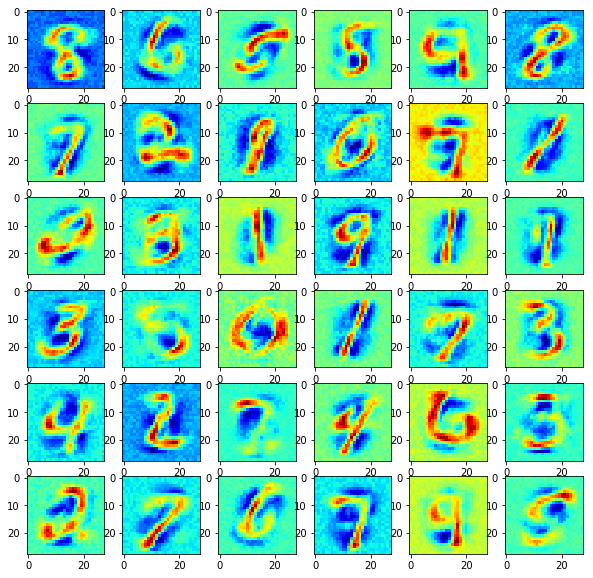

In [86]:
w = m.get_weights()

fig, axes = plt.subplots(6, 6, figsize=(10,10))

for ax, img in zip(axes.flatten(), w.T):
    ax.imshow(img.reshape((28,28)), cmap='jet')

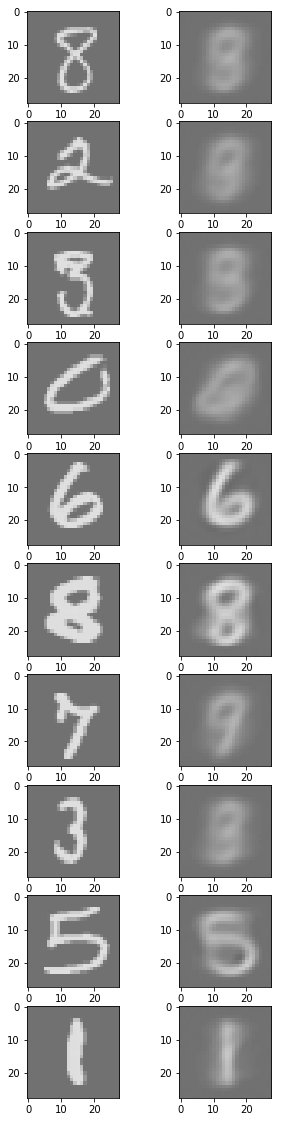

In [87]:
res = m.reconstruct(mnist_batch[:10])
fig, axes = plt.subplots(10, 2, figsize=(5,20))

for orig, rec, ax in zip(mnist_batch[:10], res, axes):
    ax[0].imshow(orig.reshape((28,28)), cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(rec.reshape((28,28)), cmap='gray', vmin=0, vmax=1)

### Natural images

In [7]:
import cv2
import glob

import gc

In [8]:
women_data = list()

for fname in glob.glob('women_of_nasa/*.jpg'):
    img = cv2.imread(fname, 0).astype(np.float32)/255.
    img_small = cv2.resize(img, (0,0), fx=0.2, fy=0.2) 
    
    x, y = img_small.shape
    
    img_cropped = img_small[int(x*0.1):int(x*0.9), int(y*0.1):int(y*0.9)]
    women_data.append(img_cropped)

In [9]:
gc.collect(0)
gc.collect(1)
gc.collect(2)

79

In [12]:
natural_hidden = 25
natural_patch = 16

In [101]:
m = SparseAutoencoder(natural_patch*natural_patch, natural_hidden, prob=0.02, weight_lambda=0.00005, optimizer=tf.train.AdamOptimizer, lr=0.01)

In [102]:
loss_hist = list()

for _ in tqdm.tnrange(5000):
    batch = get_batch(women_data, 256, natural_patch)
#     batch = normalize(batch)
    cost = m.fit(batch)
    loss_hist.append(cost)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

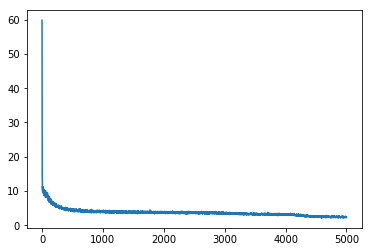

In [103]:
plt.plot(loss_hist)

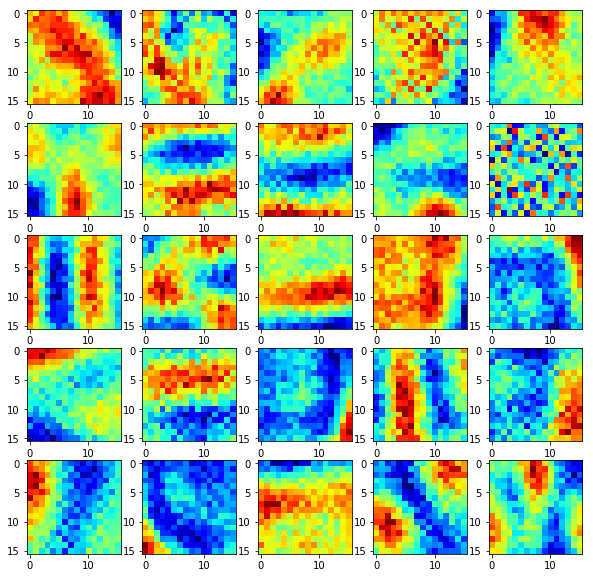

In [104]:
w = m.get_weights()

fig, axes = plt.subplots(5, 5, figsize=(10,10))

for ax, img in zip(axes.flatten(), w.T):
    ax.imshow(img.reshape((natural_patch, natural_patch)), cmap='jet')

In [23]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [28]:
test_sample = get_batch(women_data, 20000, natural_patch)

In [47]:
space_natural = {
    'prob': hp.uniform('prob', 0.01, 0.1),
    'beta': hp.uniform('beta', 2., 4.)
}

In [48]:
def target_f(params, pbar):
    m = SparseAutoencoder(natural_patch*natural_patch, natural_hidden, weight_lambda=0.00005, act_lambda=0, **params)
    
    for _ in range(1000):
        batch = get_batch(women_data, 256, natural_patch)
        m.fit(batch)
       
    loss = m.calc_mse_loss(test_sample)
    
    pbar.update(1)
    
    return {'loss': loss, 'status': STATUS_OK}


In [49]:
trials = Trials()
pbar = tqdm.tqdm_notebook(total=250)

best = fmin(lambda p: target_f(p, pbar), space_natural, algo=tpe.suggest, max_evals=100, trials=trials)

HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

In [55]:
best

{'beta': 2.490941141000597, 'prob': 0.09979954501993665}

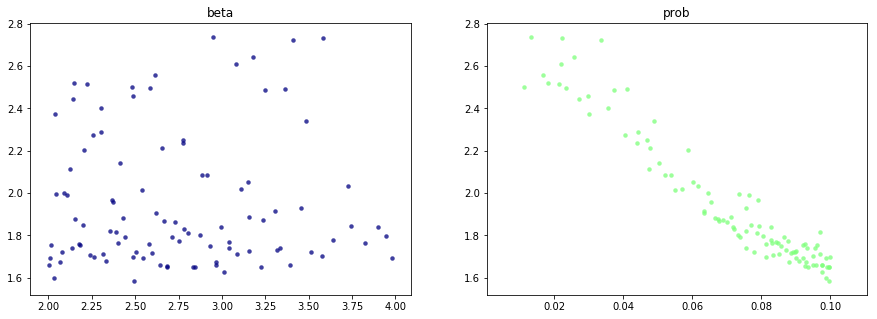

In [56]:
parameters = list(best.keys())
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

In [57]:
m = SparseAutoencoder(natural_patch*natural_patch, natural_hidden, weight_lambda=0.00005, act_lambda=0, **best)

In [58]:
loss_hist = list()

for _ in tqdm.tnrange(5000):
    batch = get_batch(women_data, 256, natural_patch)
#     batch = normalize(batch)
    cost = m.fit(batch)
    loss_hist.append(cost)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

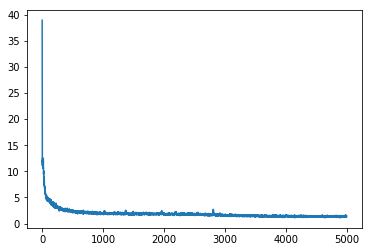

In [59]:
plt.plot(loss_hist)

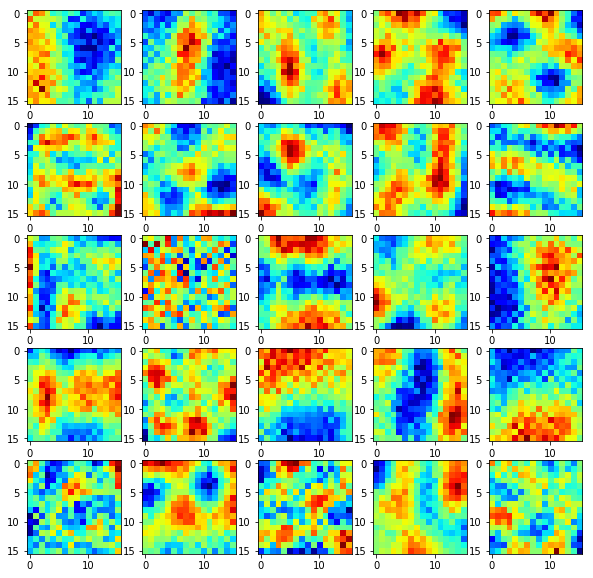

In [60]:
w = m.get_weights()

fig, axes = plt.subplots(5, 5, figsize=(10,10))

for ax, img in zip(axes.flatten(), w.T):
    ax.imshow(img.reshape((natural_patch, natural_patch)), cmap='jet')